In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.statespace.sarimax import SARIMAX
import scipy.stats as st

In [15]:
df = pd.read_csv('../data/waste.csv', sep = ';')
df['date'] = df.apply(lambda x: x['date'].split()[0]+'_'+x['date' ].split()[1], axis = 1)
df.date = pd.to_datetime(df.date, format = '%Y-%m-%d_%H')

In [16]:
df.food_category = df.food_category.astype('category')
df.reason = df.reason.astype('category')
df.location = df.location.astype('category')
df.food_category = df.food_category.astype('category')
df.food_category = df.food_category.astype('category')
df.food_category = df.food_category.astype('category')
df.food_category = df.food_category.astype('category')
df = df.sort_values('date', ascending=False).reset_index()

<Figure size 1600x900 with 0 Axes>

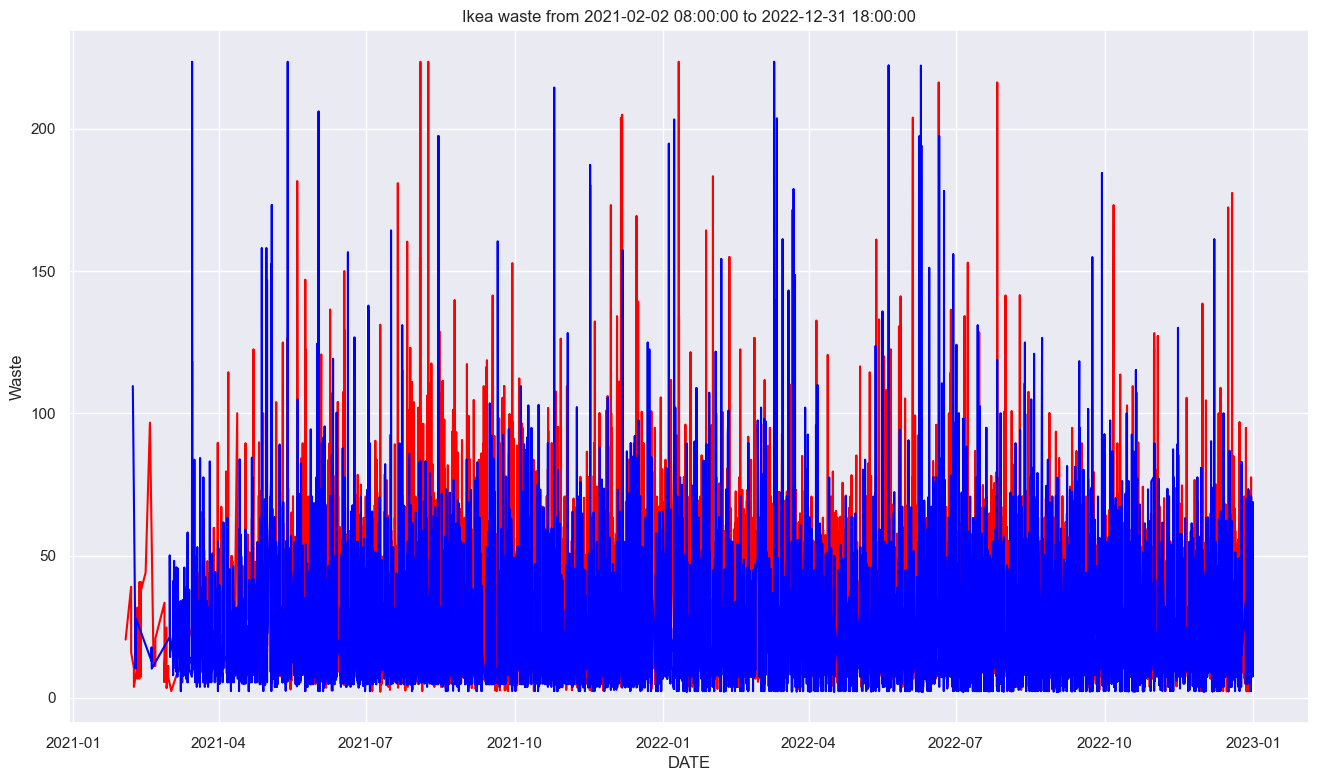

In [17]:
# Plotting a time series
sns.set(rc={'figure.figsize':(16,9)})
plt.figure(figsize=(16,9))
fig, ax = plt.subplots()
dfMad = df[df.location == 'Madrid'].copy()
dfBcn = df[df.location == 'Barcelona'].copy()
ax.plot('date','waste',data=dfMad, c = 'red')
ax.plot('date','waste',data=dfBcn, c = 'blue')
ax.set(title=f'Ikea waste from {df.date.min()} to {df.date.max()}', xlabel='DATE', ylabel='Waste')
plt.show()

In [43]:
import Billy.forecastingTools as FT
df_tsMad = pd.DataFrame(df[df.location =='Madrid']['waste'])


c:\Users\pcard\miniconda3\envs\tfGPU\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


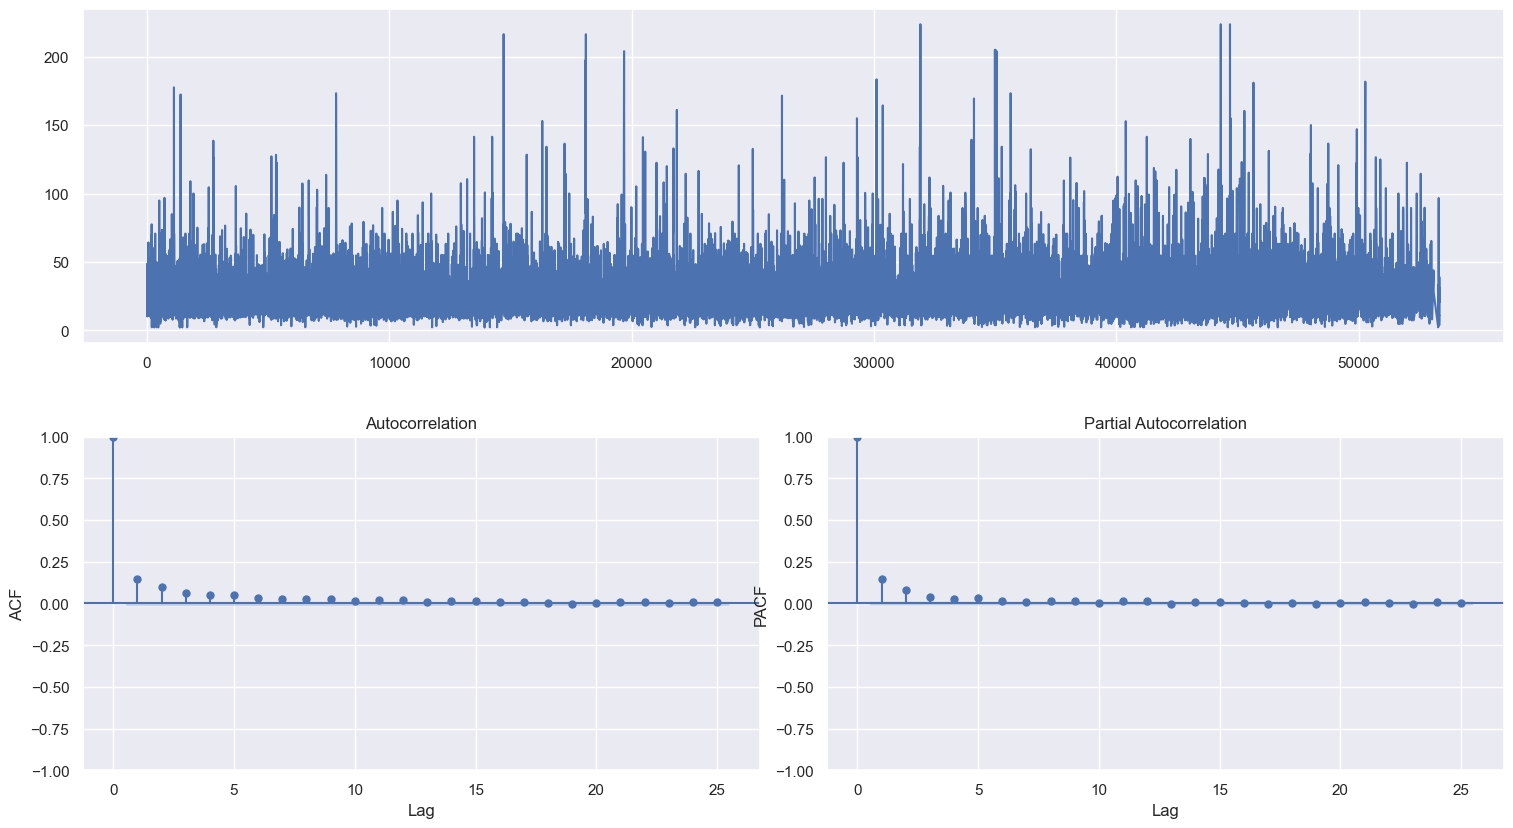

In [44]:
FT.ts_display(df_tsMad)


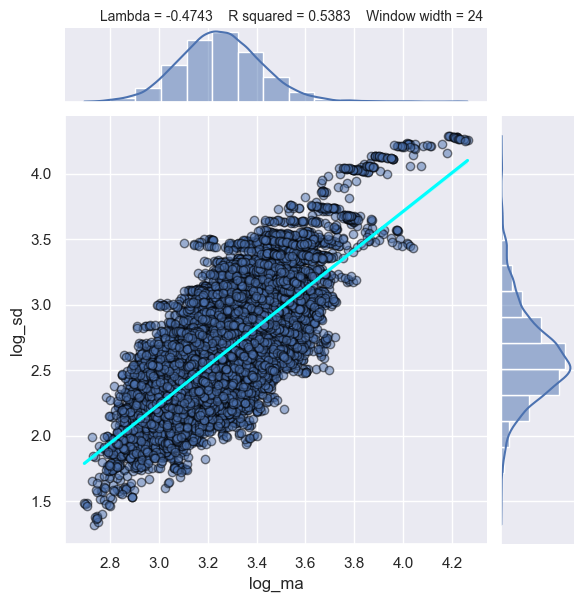

-0.47433288401522344

In [29]:
ww = 24
FT.boxcox_lambda_plot(df_tsMad, window_width=ww)

c:\Users\pcard\miniconda3\envs\tfGPU\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


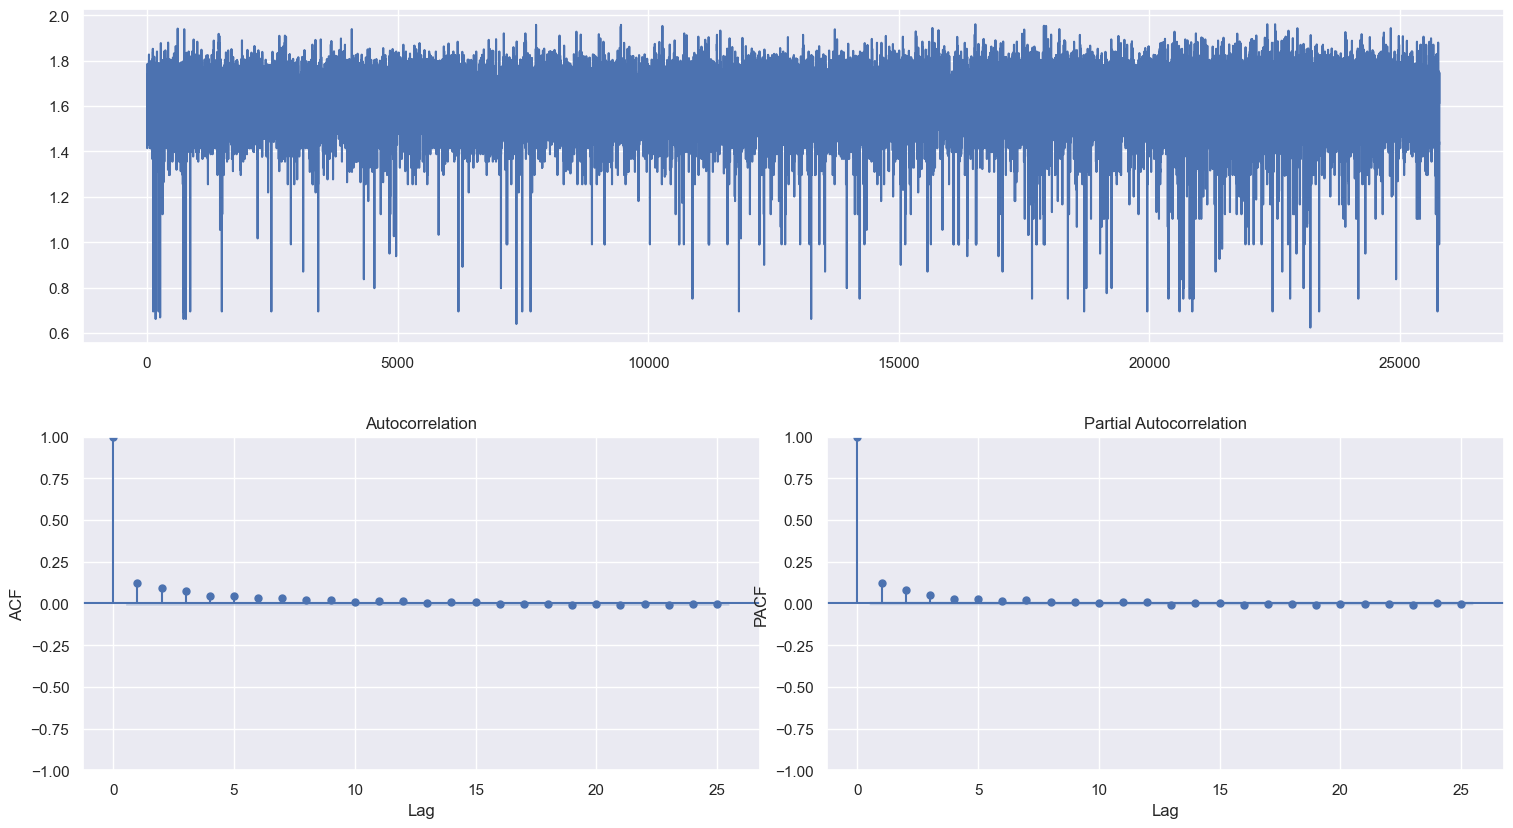

In [54]:
# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    lmbda = -0.47 #Select lambda
    z = st.boxcox(df_tsMad.values[:,0],   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df_ts.values[:,0] - min(df_ts.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=df_tsMad.columns.values.tolist())
else:
    z = df_tsMad

# Plot transformed data
FT.ts_display(z)

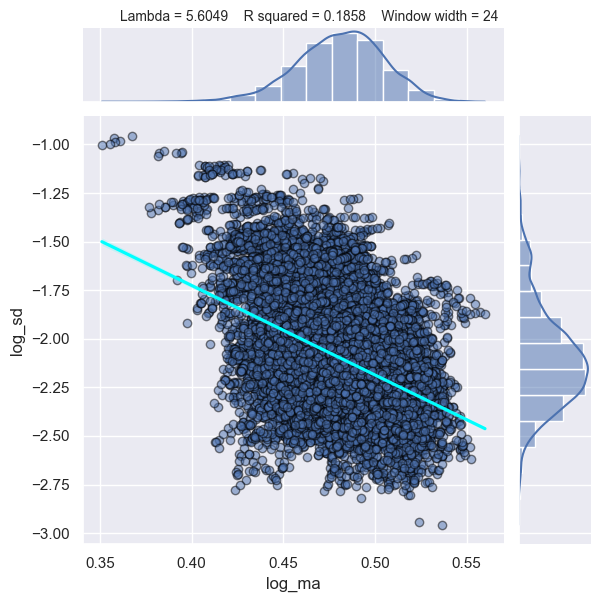

5.604878317052974

In [55]:
FT.boxcox_lambda_plot(z, window_width=ww)


c:\Users\pcard\miniconda3\envs\tfGPU\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


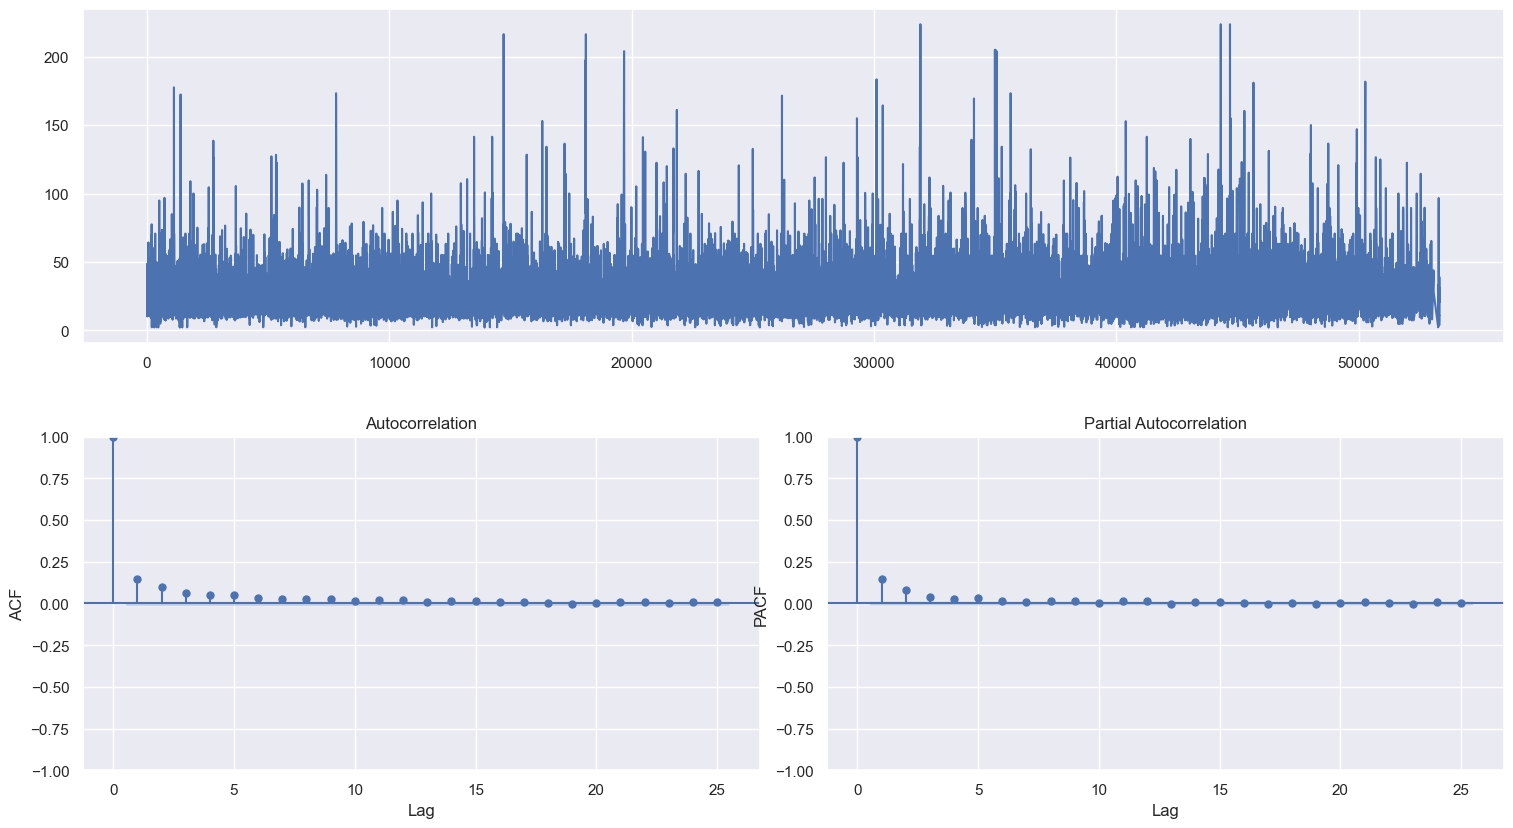

In [47]:
d = 0 #DIferenciación regular; y[t]-y[t-1]. Con eso se quita la 'tendencia gorda'
D = 0 #Diferenciación estacional; y[t]-y[t-s]. Con esto se quita la 'tendencia estacional'
#Es en este momento, con d = 1 y D = 0, donde realmente se ve la tendencia estacional de los datos, al quitar la parte regular.
S = ww # Seasonality of ww days

Bz = df_tsMad.copy()
for diff in range(d):
    Bz = Bz.diff().dropna() # drop first NA value
for seas_diff in range(D):
    Bz = Bz.diff(S).dropna() # drop first NA values
FT.ts_display(Bz)


c:\Users\pcard\miniconda3\envs\tfGPU\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\pcard\miniconda3\envs\tfGPU\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  waste   No. Observations:                25787
Model:               SARIMAX(2, 0, 2)   Log Likelihood             -108711.465
Date:                Sun, 16 Apr 2023   AIC                         217432.930
Time:                        10:54:24   BIC                         217473.718
Sample:                             0   HQIC                        217446.112
                              - 25787                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7116      0.038     18.826      0.000       0.637       0.786
ar.L2          0.2884      0.038      7.631      0.000       0.214       0.362
ma.L1         -0.6369      0.037    -17.162      0.0

c:\Users\pcard\miniconda3\envs\tfGPU\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Ljung-Box test of residuals:
       lb_stat     lb_pvalue
25  386.206901  2.056435e-66


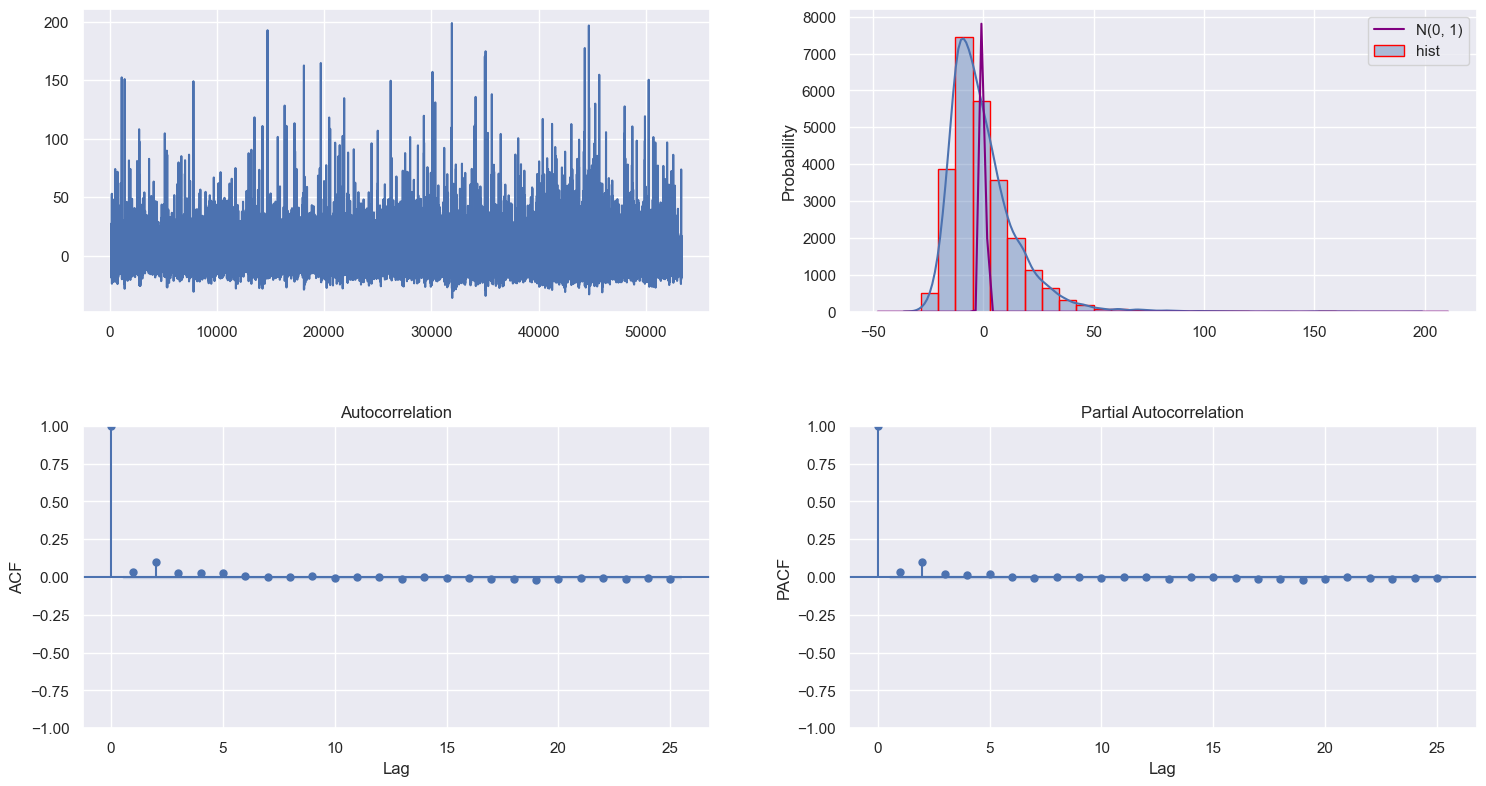

In [66]:

#Se han cambiado el valor del parámetro de diferenciación para que se haga de manera automática, usando el valor seleccionado en la celda anterior.
sarima_fit = SARIMAX(df_tsMad, 
                    order=(2,d,2), # Regular components. Para hallar estos valores nos fijamos únicamente en los primeros
                    seasonal_order=(0, D,0 , ww), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=False, 
                    enforce_stationarity=False).fit()

print(sarima_fit.summary())
FT.check_residuals(pd.DataFrame(sarima_fit.resid.loc[100:]))

c:\Users\pcard\miniconda3\envs\tfGPU\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


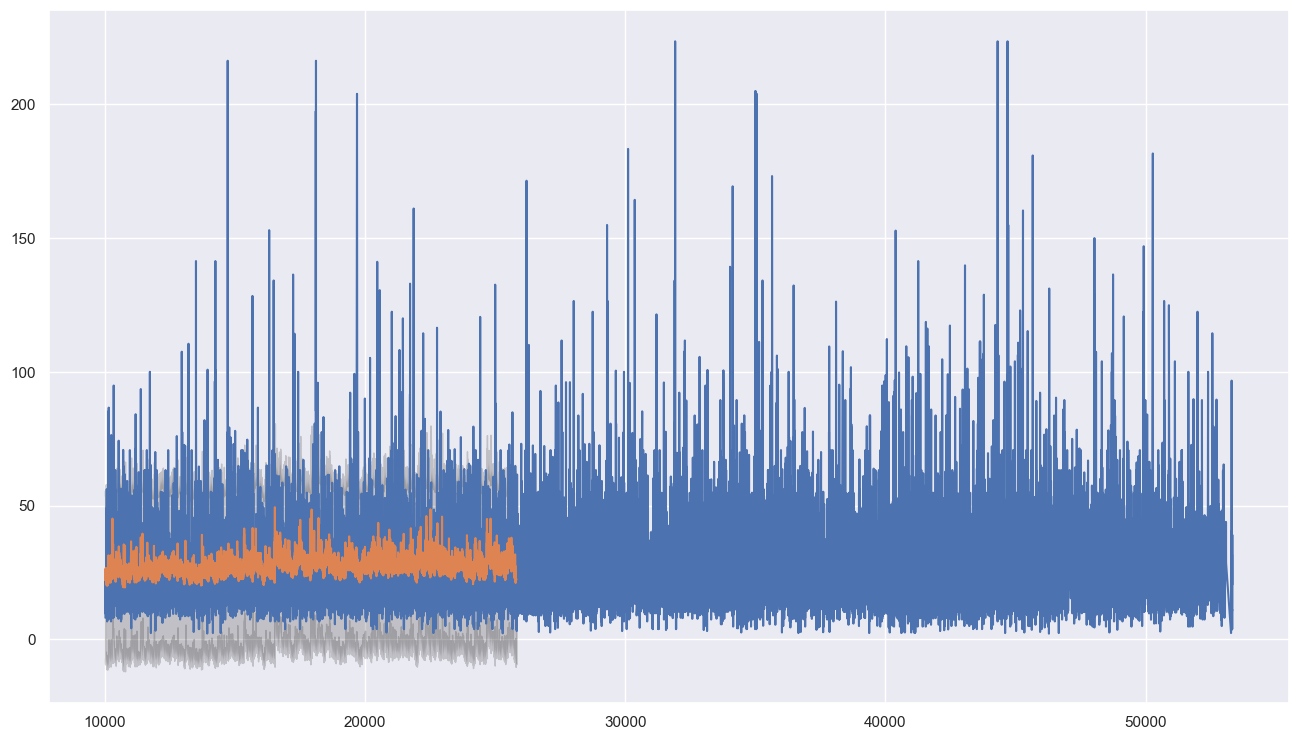

In [67]:
#Obtain forecasts for in-sample and out-of-sample
horizon = 31
start = 10000
end = df_tsMad.shape[0] + horizon

pred = sarima_fit.get_prediction(start=start, end= end, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(df_tsMad.loc[start:])
plt.plot(yhat)
plt.show()